In [76]:
'''
This step was just to be able to generate plots when running at colab.research.google.com
'''
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

'\nThis step was just to be able to generate plots when running at colab.research.google.com\n'

In [77]:
'''
Download the data from the AskNowQA space on gitHub
This can be skipped if the train-data.json and test-data.json files are already 
Available locally
'''
!curl -O 'https://raw.githubusercontent.com/AskNowQA/LC-QuAD/data/train-data.json'
!curl -O 'https://raw.githubusercontent.com/AskNowQA/LC-QuAD/data/test-data.json'

'\nDownload the data from the AskNowQA space on gitHub\nThis can be skipped if the train-data.json and test-data.json files are already \nAvailable locally\n'

In [78]:
'''
Parse the JSON data, splitting it into . The data source already split the data
in to training and test sets; we recombine so that we can perform our own split.

Each entry has the following keys:

  - _id
  - corrected_question
  - intermediary_question
  - sparql_query
  - sparql_template_id

We are interested in corrected_question (the NLQ to be translated) and 
sparql_query (the target for the translations).
'''
import json

with open('train-data.json', 'r', encoding='utf-8') as f:
  train_data = json.load(f)

with open('test-data.json', 'r', encoding='utf-8') as f:
  test_data = json.load(f)
  
source_data = train_data + test_data  
  
# quick inspection
print('\nNumber of records: {}'.format(len(source_data)))
print('\nSample pair of NLQ and SPARQL:\n')
print(source_data[0]['corrected_question'])
print(source_data[0]['sparql_query'])


Number of records: 5000

Sample pair of NLQ and SPARQL:

How many movies did Stanley Kubrick direct?
SELECT DISTINCT COUNT(?uri) WHERE {?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Stanley_Kubrick>  . }


In [79]:
# Split the dataset into the questions (NLQs) and queries (SPARQL)
import numpy as np

questions = [item['corrected_question'] for item in source_data]
queries = [item['sparql_query'] for item in source_data]

assert np.shape(questions) == np.shape(queries)

In [80]:
'''
The questions undergo fuller cleaning than the queries, removing punctuation etc.
The queries are already normalized as they are valid SPARQL statements. Two sets
are made from the queries:

  - input queries, which have a start token prepended to each
  - target queries, which have an end token appended to each

There are a few SPARQL statements where curly braces don't have spaces between them
and neighbouring tokens. We add a space around them if they don't exist.
'''
from keras.preprocessing.text import text_to_word_sequence
from pickle import dump, load
import re

default_filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
START_TOKEN = '<start>'
END_TOKEN = '<end>'

def load_clean_texts(filename):
  with open(filename, 'rb') as f:
    content = load(f)
    print('loaded {}'.format(filename))
    return content

def save_texts(texts, filename):
  with open(filename, 'wb') as f:
    dump(texts, f)
    print('saved {}'.format(filename))

def separate_special_tokens(text):
  text = re.sub(r'([^ ])([{}])', r'\1 \2', text)
  text = re.sub(r'([{}])([^ ])', r'\1 \2', text)
  text = re.sub(r'(\?uri)(\.)', r'\1 \2', text)
  return text

def clean_texts(texts, filename, filters=default_filters, lower=True, 
                start_token=None, end_token=None):
  texts = [separate_special_tokens(text) for text in texts]
  texts = [text_to_word_sequence(text, filters, lower) for text in texts]

  if start_token is not None:
    texts = [[start_token] + text for text in texts]

  if end_token is not None:
    texts = [text + [end_token] for text in texts]
  
  save_texts(texts, filename)

clean_questions = clean_texts(questions, filename='clean_questions.pkl')
clean_query_inputs = clean_texts(queries, filters='', lower=False, start_token=START_TOKEN,
                                 filename='clean_query_inputs.pkl')
clean_query_outputs = clean_texts(queries, filters='', lower=False, end_token=END_TOKEN,
                                  filename='clean_query_outputs.pkl')


saved clean_questions.pkl
saved clean_query_inputs.pkl
saved clean_query_outputs.pkl


loaded clean_questions.pkl


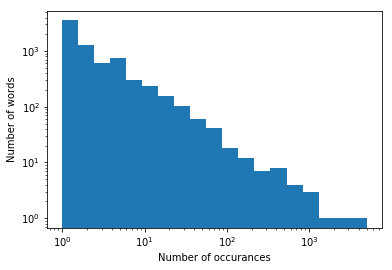

loaded clean_query_inputs.pkl


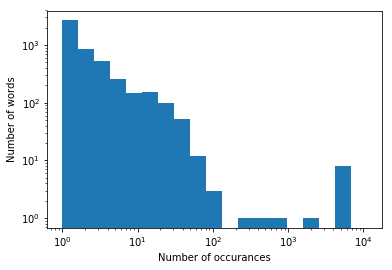

In [81]:
'''
We plot the distributions of the words in the questions and queries
to understand their different characteristics.
'''
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

def plot_word_occurances(texts):
    counter = Counter(chain.from_iterable(texts))
    x = np.array(list(counter.values()))
    fig, ax = plt.subplots()

    logbins = np.logspace(np.log10(1), np.log10(np.max(x)), 20)
    ax.hist(x, bins=logbins)

    ax.set_yscale('log')
    ax.set_ylabel('Number of words')

    ax.set_xscale('log')
    ax.set_xlabel('Number of occurances')
    plt.show()
    
clean_questions = load_clean_texts('clean_questions.pkl')
plot_word_occurances(clean_questions)

clean_queries = load_clean_texts('clean_query_inputs.pkl')
plot_word_occurances(clean_queries)

In [82]:
'''
The NLQs show the expected power law distribution of words - but the 
SPARQL queries have a set of high-frequency words that don't fit in 
that distribution. We can see below that those are a mixture of keywords
and special tokens, the core "is a" predicate:

    <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,

plus a few types that were somewhat over-represented in the generation
of the queries, such as television shows.
'''
import pprint

query_counter = Counter(chain.from_iterable(clean_queries))
top_query_tokens = query_counter.most_common(15)

pprint.pprint(top_query_tokens)

[('?uri', 11010),
 ('.', 6465),
 ('<start>', 5000),
 ('WHERE', 5000),
 ('{', 5000),
 ('}', 5000),
 ('?x', 4740),
 ('SELECT', 4632),
 ('DISTINCT', 4632),
 ('<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>', 1925),
 ('COUNT(?uri)', 658),
 ('ASK', 368),
 ('<http://dbpedia.org/ontology/TelevisionShow>', 236),
 ('<http://dbpedia.org/ontology/Person>', 132),
 ('<http://dbpedia.org/ontology/Film>', 113)]


In [83]:
import string
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

class Encoder:
  '''
  Class creates a tokenizer used for vectorizing texts. It can also create a one-hot
  encoded version of the text vectors, which as the target of the predictions.
  '''

  def __init__(self, texts):
    self.texts = texts
    self.tokenizer = Tokenizer()
    self.tokenizer.fit_on_texts(self.texts)
    self.inverter = dict((v, k) for k, v in self.tokenizer.word_index.items())
    self.maxlen = max(len(text) for text in self.texts)
    self.vocab_size = len(self.tokenizer.word_index) + 1    
    self.report()

  def report(self):
    print('---')
    print('vocab size: {}'.format(self.vocab_size))
    print('sequence lengths: {}'.format(self.maxlen))
    print('sample: "{}"'.format(' '.join(self.texts[100])))
    
    sample_word = self.texts[0][0]    
    hot_encoded_sample_word = self.to_categorical(texts=[sample_word.split()], maxlen=1)
    decoded_hot_encoded = self.decode_categorical(one_hot_sequence=hot_encoded_sample_word)
    print('decoded encoded sample word: {}'.format(decoded_hot_encoded))
  
  def encode_text(self, text, pad_to_length):
    return self.encode_texts(texts=[text.split()], maxlen=pad_to_length)
  
  def encode_texts(self, texts, maxlen=None):
    if maxlen is None:
      maxlen = self.maxlen
    sequences = self.tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen, padding='post')

  def encoded(self):
    return self.encode_texts(self.texts)

  def decode_tokens(self, sequence):
    sentence = list()
    for token in sequence:
      if token == 0:
        break
      sentence.append(self.inverter[token])
    return ' '.join(sentence)

  def to_categorical(self, texts, maxlen=None):
    encoded = self.encode_texts(texts, maxlen)
    categorical = [to_categorical(text, num_classes=self.vocab_size) for text in encoded]
    return np.array(categorical).reshape(encoded.shape[0], encoded.shape[1], self.vocab_size)

  def categorical_encoded(self):
    encoded = self.encoded()
    return self.to_categorical(encoded)
          
  def decode_categorical(self, one_hot_sequence):
    sequence = [np.argmax(v) for v in one_hot_sequence]
    return self.decode_tokens(sequence)
   

In [84]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
import re

class QuestionToQuery:
  '''
  Instance of the training + inference models, used as convenience to run 
  different hyperparameters.
  '''

  def __init__(self, latent_dim, epochs, batch_size, optimizer, dropout, recurrent_dropout,
               questions_vocab_size, query_vocab_size, question_length, query_length):

    self.latent_dim = latent_dim
    self.epochs = epochs
    self.batch_size = batch_size
    self.optimizer = optimizer
    self.dropout = dropout
    self.recurrent_dropout = recurrent_dropout
    
    self.questions_vocab_size = questions_vocab_size
    self.query_vocab_size = query_vocab_size
    self.question_length = question_length
    self.query_length = query_length
    dirty_name = 'model_{}_{}_{}_{}_{}_{}'.format(latent_dim, epochs, batch_size, optimizer,
                                                 dropout, recurrent_dropout)
    self.name = re.sub(r'\.', '', dirty_name)
    self.init_training_model()
    self.init_inference_model()
  
  def init_training_model(self):
    '''
    The Training Model trains embedding and LSTM layers, and the encoder state.
    '''
    self.encoder_inputs = Input(shape=(None,))

    x = Embedding(input_dim=self.questions_vocab_size,
                  output_dim=self.latent_dim,
                  mask_zero=True,
                  input_length=self.question_length)
    encoder_embedding_outputs = x(self.encoder_inputs)

    
    x = LSTM(units=self.latent_dim, 
             return_state=True, 
             dropout=self.dropout,
             recurrent_dropout=self.recurrent_dropout)
    _, state_h, state_c = x(encoder_embedding_outputs)
    self.encoder_states = [state_h, state_c]

    self.decoder_inputs = Input(shape=(None,))
    
    x = Embedding(input_dim=self.query_vocab_size,
                  output_dim=self.latent_dim,
                  mask_zero=True,
                  input_length=self.query_length)
    self.decoder_embedding_outputs = x(self.decoder_inputs)

    self.decoder_lstm = LSTM(units=self.latent_dim, return_sequences=True, return_state=True,
                             dropout=0.2, recurrent_dropout=0.2)
    decoder_lstm_outputs, _, _ = self.decoder_lstm(self.decoder_embedding_outputs, 
                                                   initial_state=self.encoder_states)
    
    self.decoder_dense = Dense(units=self.query_vocab_size, activation='softmax')
    decoder_outputs = self.decoder_dense(decoder_lstm_outputs)

    self.training_model = Model(inputs=[self.encoder_inputs, self.decoder_inputs], 
                                outputs=decoder_outputs)
    self.training_model.compile(optimizer=self.optimizer,
                                loss='categorical_crossentropy', 
                                metrics=['accuracy'])

  def init_inference_model(self):
    '''
    Model for generating predictions of SPARQL queries from questions. Uses inputs from
    the training model.
    '''
    self.encoder_model = Model(inputs=self.encoder_inputs, outputs=self.encoder_states)
    encoder_outputs = Input(shape=(None, self.latent_dim))

    input_h = Input(shape=(self.latent_dim,))
    input_c = Input(shape=(self.latent_dim,))
    input_states = [input_h, input_c]

    inference_lstm_outputs, inference_h, inference_c = \
      self.decoder_lstm(self.decoder_embedding_outputs, initial_state=input_states)

    inference_states = [inference_h, inference_c]
    inference_outputs = self.decoder_dense(inference_lstm_outputs)

    self.inference_model = Model([self.decoder_inputs] + input_states,
                                 [inference_outputs] + inference_states)
  
  def summary(self):
    print(self.training_model.summary())
    print(self.encoder_model.summary())
    print(self.inference_model.summary())
    
  def plot_models(self):
    plot_model(training_model, to_file='training_model.png', show_shapes=True)    
    plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)    
    plot_model(inference_model, to_file='inference_model.png', show_shapes=True)
    
  def train(self, questions, query_inputs, query_outputs):
    assert len(questions) == len(query_inputs)
    assert len(query_inputs) == len(query_outputs)
    
    train_X = [questions, query_inputs]
    train_y = query_outputs

    checkpoint = ModelCheckpoint('training_{}.h5'.format(self.name), monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min')
    self.history = self.training_model.fit(x=train_X, y=train_y, 
                                           batch_size=self.batch_size, 
                                           epochs=self.epochs, 
                                           validation_split=0.1,
                                           callbacks=[checkpoint],
                                           verbose=2)
  
  def plot_training(self):
    pyplot.plot(self.history.history['loss'])
    pyplot.plot(self.history.history['val_loss'])
    pyplot.title('Training vs Validation Loss')
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['train', 'val'], loc='upper left')
    pyplot.savefig('loss_{}'.format(self.name))
    pyplot.gcf().clear()

    pyplot.plot(self.history.history['acc'])
    pyplot.plot(self.history.history['val_acc'])
    pyplot.title('Training vs Validation Accuracy')
    pyplot.ylabel('Accuracy')
    pyplot.xlabel('Epoch')
    pyplot.legend(['train', 'val'], loc='upper left')
    pyplot.savefig('accuracy_{}'.format(self.name))
    pyplot.gcf().clear()


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

class ModelEvaluation:
  '''
  Evaluates the inference model using the BLEU score for 1-4 grams. The evaluation
  is done comparing predictions from questions to target queries 
  '''

  def __init__(self, model, query_inputs_encoder, query_outputs_encoder, query_length):
    self.model = model
    self.query_inputs_encoder = query_inputs_encoder
    self.query_outputs_encoder = query_outputs_encoder
    self.query_length = query_length

  def question_to_query(self, question):
    states_value = self.model.encoder_model.predict(question)   
    inference_input = self.query_inputs_encoder.encode_text(START_TOKEN, 
                                                            pad_to_length=self.query_length)
    decoded_sentence = list()

    while True:
      output_tokens, h, c = self.model.inference_model.predict([inference_input, 
                                                                states_value[0], 
                                                                states_value[1]])
      
      decoded_word = self.query_outputs_encoder.decode_categorical(output_tokens)
      
      if (decoded_word == END_TOKEN or len(decoded_sentence) >= self.query_outputs_encoder.maxlen):
        break

      decoded_sentence.append(decoded_word)
      inference_input = self.query_inputs_encoder.encode_text(decoded_word, 
                                                              pad_to_length=self.query_length)
      states_value = h, c

    return decoded_sentence

  def run(self, questions, target_queries):
    target = list()
    predicted = list()
    for i, question in enumerate(questions):
      target_query = self.query_outputs_encoder.decode_categorical(target_queries[i])
      target.append(target_query.split())

      predicted_query = self.question_to_query(question)
      predicted.append(predicted_query)

      if i < 10:
        print('\nSample translation:')
        print('Question: {}'.format(questions_encoder.decode_tokens(question)))
        print('Target SPARQL: {}'.format(target_query))
        print('Predicted SPARQL: {}'.format(' '.join(predicted_query)))

    bleu_1 = corpus_bleu(target, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(target, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(target, predicted, weights=(0.333, 0.333, 0.333, 0))
    bleu_4 = corpus_bleu(target, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return dict(bleu_1=bleu_1, bleu_2=bleu_2, bleu_3=bleu_3, bleu_4=bleu_4)

In [ ]:
'''
Run the training and evaluation, varying the following hyper-parameters:

    - number of units
    - epochs
    - batch size
    
'''
import itertools
from sklearn.model_selection import train_test_split
 
clean_questions = load_clean_texts('clean_questions.pkl')
clean_query_inputs = load_clean_texts('clean_query_inputs.pkl')
clean_query_outputs = load_clean_texts('clean_query_outputs.pkl')

questions_encoder = Encoder(clean_questions)
query_inputs_encoder = Encoder(clean_query_inputs)
query_outputs_encoder = Encoder(clean_query_outputs)

encoded_questions = questions_encoder.encode_texts(clean_questions)
encoded_query_inputs = query_inputs_encoder.encode_texts(clean_query_inputs)
encoded_query_outputs = query_outputs_encoder.to_categorical(clean_query_outputs)

questions_train, questions_test, query_inputs_train, query_inputs_test, query_outputs_train, \
  query_outputs_test = train_test_split(encoded_questions, encoded_query_inputs, 
                                        encoded_query_outputs, test_size=0.1, random_state=9)

questions_vocab_size = questions_encoder.vocab_size
query_vocab_size = query_inputs_encoder.vocab_size

hyperparam_sets = itertools.product([64, 128, 256], [32, 64], ['adam', 'rmsprop'], [0.0, 0.5])
epochs = 100

for latent_dim, batch_size, optimizer, dropout in hyperparam_sets:
  print('=' * 100)
  print('Running hyperparameter set: latent_dim: {}, epochs: {}, batch_size: {}, optimizer: {}, dropout: {}'
        .format(latent_dim, epochs, batch_size, optimizer, dropout))
  
  model = QuestionToQuery(latent_dim=latent_dim, 
                          epochs=100,
                          batch_size=batch_size,
                          optimizer=optimizer,
                          dropout=dropout, 
                          recurrent_dropout=dropout,
                          questions_vocab_size=questions_vocab_size, 
                          query_vocab_size=query_vocab_size,
                          question_length=questions_encoder.maxlen, 
                          query_length=query_inputs_encoder.maxlen)

  model.train(questions=questions_train, 
              query_inputs=query_inputs_train,
              query_outputs=query_outputs_train)
  model.plot_training()

  evaluation = ModelEvaluation(model=model,
                               query_inputs_encoder=query_inputs_encoder,
                               query_outputs_encoder=query_outputs_encoder,
                               query_length=query_inputs_encoder.maxlen)
  
  training_bleu_scores = evaluation.run(questions=questions_train, 
                                        target_queries=query_outputs_train)
  print('Training BLEU scores: {}\n'.format(training_bleu_scores))
  
  test_bleu_scores = evaluation.run(questions=questions_test, 
                                    target_queries=query_outputs_test)
  print('Test BLEU scores: {}\n'.format(test_bleu_scores))

loaded clean_questions.pkl
loaded clean_query_inputs.pkl
loaded clean_query_outputs.pkl
---
vocab size: 7116
sequence lengths: 25
sample: "who won a norbert wiener award for social and professional responsibility"
decoded encoded sample word: how
---
vocab size: 4728
sequence lengths: 18
sample: "<start> SELECT DISTINCT ?uri WHERE { ?uri <http://dbpedia.org/property/prizes> <http://dbpedia.org/resource/Norbert_Wiener_Award_for_Social_and_Professional_Responsibility> . }"
decoded encoded sample word: <start>
---
vocab size: 4728
sequence lengths: 18
sample: "SELECT DISTINCT ?uri WHERE { ?uri <http://dbpedia.org/property/prizes> <http://dbpedia.org/resource/Norbert_Wiener_Award_for_Social_and_Professional_Responsibility> . } <end>"
decoded encoded sample word: select
Running hyperparameter set: latent_dim: 64, epochs: 100, batch_size: 32, optimizer: adam, dropout: 0.0
Train on 4050 samples, validate on 450 samples
Epoch 1/100
